## Prepare

### Resources Paths

In [6]:
import glob

PROJECT_ROOT_PATH = '../../../..'
TEMP_PATH = PROJECT_ROOT_PATH + '/tmp'
DATA_PATH  = TEMP_PATH + '/detect/data'
MODEL_PATH = TEMP_PATH + '/detect/model'

WORDS_TRAIN_PATH = DATA_PATH + '/words.train.tsv'
WORDS_TEST_PATH = DATA_PATH + '/words.test.tsv'
LABELS_TRAIN_PATH = DATA_PATH + '/labels.train.tsv'
LABELS_TEST_PATH = DATA_PATH + '/labels.test.tsv'

FEATURES_TEST_PATH = sorted(glob.glob(DATA_PATH + "/*Feature*"))

print(len(FEATURES_TEST_PATH))

42


In [7]:
import os

for path in FEATURES_TEST_PATH:
    print(os.path.basename(path)[:-4])

ApproximateContextCoherenceFeature$bigram
ApproximateContextCoherenceFeature$fivegram
ApproximateContextCoherenceFeature$fourgram
ApproximateContextCoherenceFeature$trigram
CharacterExistenceFeature$123
CharacterExistenceFeature$124
CharacterExistenceFeature$125
CharacterExistenceFeature$126
CharacterExistenceFeature$127
CharacterExistenceFeature$32
CharacterExistenceFeature$33
CharacterExistenceFeature$34
CharacterExistenceFeature$35
CharacterExistenceFeature$36
CharacterExistenceFeature$37
CharacterExistenceFeature$38
CharacterExistenceFeature$39
CharacterExistenceFeature$40
CharacterExistenceFeature$41
CharacterExistenceFeature$42
CharacterExistenceFeature$43
CharacterExistenceFeature$44
CharacterExistenceFeature$45
CharacterExistenceFeature$46
CharacterExistenceFeature$47
CharacterExistenceFeature$59
CharacterExistenceFeature$60
CharacterExistenceFeature$61
CharacterExistenceFeature$62
CharacterExistenceFeature$63
CharacterExistenceFeature$64
CharacterExistenceFeature$91
CharacterE

### Evaluation Data

We tokenize the OCR text using the proposed unsupervised segmentation approach.
Each token is labeled according to whether overlapping with any ground truth error.
We then split the token sequence at the position after the first 80% of the ground truth errors are encountered and use two splits for training and testing respectively.

In [8]:
import csv
import pandas as pd

def read_words(path):
    col_names = ["w-4", "w-3", "w-2", "w-1", "w", "w+1", "w+2", "w+3", "pos"]
    return pd.read_table(open(path, 'r'), header=None, quoting=csv.QUOTE_NONE, names=col_names)

def read_vals(path, name=None):
    return pd.read_table(open(path, 'r'), header=None, names=[name])

def read_labels(path):
    return read_vals(path, 'label')

def read_feat_vals(path):
    name = path[path[:-4].rfind('/') + 1:-4]
    return read_vals(path, name)

def read_feats(paths):
    feats_vals = [read_feat_vals(p) for p in paths]
    return pd.concat(feats_vals, axis=1)

In [9]:
WORDS_TRAIN  = read_words(WORDS_TRAIN_PATH)
WORDS_TEST   = read_words(WORDS_TEST_PATH)
LABELS_TRAIN = read_labels(LABELS_TRAIN_PATH)
LABELS_TEST  = read_labels(LABELS_TEST_PATH)

feats = read_feats(FEATURES_TEST_PATH)
FEATS_TRAIN = feats[:WORDS_TRAIN.shape[0]]
FEATS_TEST  = feats[WORDS_TRAIN.shape[0]:]
feats = None

## Detection Model Evaluation

We validate each model setting using cross-validation.

In [10]:
W_FNR = 0.5
W_FPR = 0.5

def eval_model(y, y_hat, anomaly=False):
    """ Evaluate the prediction results. """
    label_cls = [-1, 1] if anomaly else [1, 0]
    cm = metrics.confusion_matrix(y_hat, y, labels=label_cls)
    tp = cm[0][0]
    fp = cm[1][0]
    fn = cm[0][1]
    tn = cm[1][1]
    rec = cm[0][0] / (cm[0][0] + cm[0][1])
    metric = 1 - W_FNR * (fn / (tp + fn) + W_FPR * fp / (fp + tn)) 
    return rec, metric, tp, fp


def better_model(model_info_1, model_info_2):
    """ Compare and return a model with the better evaluated values. """
    name_1, rec_1, metric_1, tp_1, fp_1 = model_info_1
    name_2, rec_2, metric_2, tp_2, fp_2 = model_info_2
    
    if   metric_1 > metric_2: return model_info_1
    elif metric_1 < metric_2: return model_info_2
    elif recall_1 > recall_2: return model_info_1
    elif recall_1 < recall_2: return model_info_2
    elif fp_1 < fp_2: return model_info_1
    elif fp_1 > fp_2: return model_info_2
    else: return model_info_1

In [11]:
def _display_seg():
    print('-' * 80)
    
def _display_head():
    print('  %-30s        %8s %12s %8s %8s' % ('Model', 'Recall', 'Metric', 'TP', 'FP'))
    _display_seg()

def _display(name, is_computed, recall, metric, tp, fp):
    status = '*' if is_computed else ' '
    print('%1s %-30s        %8.4f %12.4f %8d %8d' % (status, name, recall, metric, tp, fp))

In [12]:
def validate(models, anomaly=False):
    """ Validate models. """
    # Transform labels for anomaly detection models.
    train_labels = LABELS_TRAIN['label'].replace(1, -1).replace(0, 1) if anomaly else LABELS_TRAIN
    # Reshape the labels to shape (N,)
    num = LABELS_TRAIN.shape[0]
    train_labels = train_labels.as_matrix().reshape(num,)
    
    _display_head()
    max_model_info = None
    for (name, clf) in models:
        # Get the file path to the validation result.
        val_path = MODEL_PATH + '/' + '%s.val.txt' % name
        
        # Load results from file if the results are previously computed. Otherwise, compute the
        # result using cross validation.
        if os.path.exists(val_path):
            trained = False
            y = read_vals(val_path)
        else:
            trained = True
            y = model_selection.cross_val_predict(clf, FEATS_TRAIN, y=train_labels, cv=10)
            with open(val_path, 'w') as val_file:
                val_file.write('\n'.join([str(v) for v in y]))
        recall, metric, tp, fp = eval_model(y, train_labels, anomaly)
        _display(name, trained, recall, metric, tp, fp)
        
        # Compare and update the best performing model.
        model_info = (name, recall, metric, tp, fp)
        max_model_info = better_model(max_model_info, model_info) if max_model_info else model_info
        
    # Print the best performing model.
    _display_seg()
    name, recall, metric, tp, fp = max_model_info
    _display(name, False, recall, metric, tp, fp)
    return name

We evaluate different models for predicting token correctness.
For each model, we grid search the optimal hyperparameter setting, where each setting are evaluated by the prediction accuracy using 10-fold cross-validation.

In [13]:
import os
import shutil
from sklearn import metrics
from sklearn import model_selection
from sklearn.externals import joblib
import sys
import time

FORCE_RETRAIN = False

lab = LABELS_TEST.to_dict()['label'].values()
COE_A = 1
COE_B = sum(lab) / (len(lab) - sum(lab))

def get_pkl_path(name):
    return MODEL_PATH + '/' + '%s.pkl' % name

__train_time = {}  # cached training time

def train(models, retrain=False, log=True, anomaly=False):
    if FORCE_RETRAIN:
        shutil.rmtree(MODEL_PATH)
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)
    train_labels = LABELS_TEST['label'].replace(1, -1).replace(0, 1) if anomaly else LABELS_TRAIN
    for (name, clf) in models:
        if log: sys.stdout.write('%-30s ..... ' % name)
        pkl_path = get_pkl_path(name)
        if retrain or not os.path.exists(pkl_path):
            str_time = time.time()
            clf.fit(FEATS_TRAIN, train_labels.as_matrix().ravel())
            elapsed_time = (time.time() - str_time)
            joblib.dump(clf, pkl_path, compress=9)
            __train_time[name] = elapsed_time
            if log: sys.stdout.write('TRAINED')
        else:
            elapsed_time = __train_time[name] if name in __train_time else None
            if log: sys.stdout.write('SKIPPED') 
        if elapsed_time:
            if log: sys.stdout.write(' (%.3f seconds)' % elapsed_time)
        if log: print()

def test(models, best_cv_model, anomaly=False):
    _display_head()
    for (name, _) in models:
        clf = joblib.load(get_pkl_path(name))
        preds = clf.predict(FEATS_TEST)
        test_labels = LABELS_TEST['label'].replace(1, -1).replace(0, 1) if anomaly else LABELS_TEST
        label_cls = [-1, 1] if anomaly else [1, 0]
        recall, metric, tp, fp = eval_model(preds, test_labels, anomaly)
        record = name, False, recall, metric, tp, fp
        _display(*record)
        if best_cv_model is name:
            best_cv_record = record
    # Print the train result for the best model evaluated in CV.
    _display_seg()
    _display(*best_cv_record)
    return best_cv_record

def result(best_cv_record):
    _display(*best_cv_record)
        
        
def report(models, anomaly=False):
    """ Print out the confusion matrix for each model. """
    for (name, _) in models:
        clf = joblib.load(get_pkl_path(name))
        preds = clf.predict(FEATS_TEST)
        test_labels = LABELS_TEST['label'].replace(1, -1).replace(0, 1) if anomaly else LABELS_TEST
        rep = metrics.classification_report(test_labels, preds, digits=4)
        print('%-30s\n\n%s' % (name, rep))


def diff(model_name1, model_name2):
    def print_word(idx):
        s = WORDS_TEST.loc[i]
        return '%-10s %s %s' % (s['w'],s['pos'], LABELS_TEST.loc[i]['label'])
    def pred(model_name):
        clf = joblib.load(get_pkl_path(model_name))
        return clf.predict(FEATS_TEST)
    pred1 = pred(model_name1)
    pred2 = pred(model_name2)
    diff = [''] * len(pred1)
    for i, (x, y) in enumerate(zip(pred1, pred2)):
        if x == 1 and y == 0:
            print('+', print_word(i))
        elif x == 0 and y == 1:
            print('-', print_word(i))

def get_clf(name):
    return joblib.load(get_pkl_path(name))

In [ ]:
1 / COE_B * 10000000

In [147]:
diff('DTree.wE8', 'ETree.wE8')

- possibility 407374 0
- Ravens     407568 0
- built      407651 0
+ fern       407749 0
+ On         407850 0
+ two        407863 0
+ tlie       407886 1
- nest       407891 0
+ Lord       408057 0
+ Lilford    408062 0
+ liowever   408102 1
+ had        408112 0
+ reared     408138 0
+ In         408196 0
+ out        408237 0
+ five       408241 0
- .          408263 0
- S.         408298 0
+ forwarded  408308 0
+ Buzzard    408354 0
- taken      408362 0
+ tame       408456 0
+ within     408461 0
+ Buzzard    408484 0
- remained   408492 0
+ obdurate   408501 0
+ for        408510 0
+ suspicion  408559 0
- '          408678 0
+ Raven      408689 0
+ instantly  408819 0
+ dashed     408829 0
+ The        408915 0
- after      408928 0
+ flying     408934 0
+ pursued    408984 0
- '          409003 0
+ suddenly   409005 0
+ alighted   409014 0
+ .          409083 0
- bird       409109 0
+ Odin       409117 0
+ was        409122 0
- tempered   409136 0
+ Buzzard    409271 0
+ was    

- parent     435485 0
+ young      435566 0
+ Yet        435637 0
- and        435721 0
+ ever       435725 0
+ wants      435757 0
+ Crow       435838 0
- depredations 435843 0
+ could      435861 0
+ whom       435986 0
+ hand       436004 0
+ cylinder   436121 0
+ pointed    436130 0
+ upwards    436138 0
+ is         436146 0
+ How        436289 1
+ -          436292 1
+ ;          436343 0
+ Robin      436353 0
- babies     436359 0
+ Crow       436401 0
- babies     436406 0
- ignores    436447 0
- and        436673 0
+ incessant  436743 0
- .          436855 0
+ -          436947 0
+ arid       436959 0
+ mollusca   436991 0
+ carrion    437035 0
- fruits     437092 0
+ ;          437132 0
- but        437134 0
+ refuse     437205 0
+ heaps      437212 0
+ or         437218 0
- cast       437237 0
- though     437260 0
- sparrows   437324 0
+ ;          437408 0
+ Mr.        437490 0
- writes     437511 0
- but        437544 0
+ Carrion    437558 0
+ f          437719 1
+ THE   

+ itself     464914 0
+ glide      464984 0
+ Its        465051 0
+ Lark       465107 0
+ is         465139 0
- seen       465153 0
+ and        465179 0
- parties    465191 0
+ liquid     465221 0
+ uttered    465272 0
+ hai        465399 0
+ horse      465559 0
- he         465649 0
+ soar       465674 0
- describes  465802 0
- 3          465890 1
+ with       465931 0
- chiefly    466031 0
- nor        466210 0
+ the        466217 0
+ It         466270 0
+ open       466285 0
+ It         466361 0
+ A.         466412 0
+ In         466451 0
+ flocks     466523 0
+ barren     466557 0
- states     466703 0
+ Bunting    466778 0
- caged      466820 0
+ custom     466944 0
+ Herr       467233 0
+ as         467272 0
+ adult      467332 0
+ wild       467338 0
+ song       467343 0
+ Herr       467408 0
+ like       467421 0
+ Bunting    467481 0
+ it         467494 0
+ This       467622 0
+ tlie       467641 1
+ Persian    467680 0
- specimens  467688 0
- have       467708 0
+ liquid  

+ The        490622 0
+ Breconshire 490675 0
+ A          490713 0
- one        490844 0
- Scilly     490961 0
- 1905       490986 0
- visited    491197 0
+ Shetlands  491209 0
- between    491219 0
- 1904       491249 0
- one        491280 0
- at         491316 0
- 27th       491340 0
- .          491419 0
+ Siberian   491426 0
+ Chiffchaff 491435 0
+ .          491445 0
+ ,          491469 0
+ example    491481 0
- off        491518 0
+ .          491541 0
+ I          491578 1
- .          491586 0
+ Greenish   491593 0
- Willow     491602 0
+ ,          491644 0
- 1896       491712 0
+ Skerry     491739 0
+ Lighthouse 491746 0
+ Two        491801 0
- Willow     491827 0
+ were       491842 0
+ The        491915 0
+ TL         491995 1
+ Z          492026 1
+ J          492028 1
+ .          492033 1
+ Rufous     492043 0
+ Warbler    492050 0
+ ,          492076 0
+ THIS       492085 0
+ rare       492090 0
- .          492193 0
- -          492204 0
+ A          492242 0
+ TURD   

### Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier as DTree
dt_models = [
    ['DTree',            DTree()],
    ['DTree.balanced',   DTree(class_weight='balanced')],
    ['DTree.wE3',        DTree(class_weight={0:1, 1:1000})],
    ['DTree.wE4',        DTree(class_weight={0:1, 1:10000})],
    ['DTree.wE5',        DTree(class_weight={0:1, 1:100000})],
    ['DTree.wE6',        DTree(class_weight={0:1, 1:1000000})],
    ['DTree.wE7',        DTree(class_weight={0:1, 1:10000000})],
    ['DTree.wE8',        DTree(class_weight={0:1, 1:100000000})],
    ['DTree.wE8.wf-2',   DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.2)],
    ['DTree.wE8.wfE-1',  DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.1)],
    ['DTree.wE8.wfE-2',  DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.01)],
    ['DTree.wE8.wfE-3',  DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.001)],
    ['DTree.wE8.wfE-4',  DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.0001)],
    ['DTree.wE8.wfE-5',  DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.00001)],
    ['DTree.wE8.wfE-6',  DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.000001)],
    ['DTree.wE8.wfE-7',  DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.0000001)],
    ['DTree.wE8.wfE-8',  DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.00000001)],
    ['DTree.wE8.wfE-9',  DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.000000001)],
    ['DTree.wE8.wfE-10', DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.0000000001)],
    ['DTree.wE8.wfE-10.d10', DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.0000000001, max_depth=10)],
    ['DTree.wE8.wfE-10.d20', DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.0000000001, max_depth=20)],
    ['DTree.wE8.wfE-10.d30', DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.0000000001, max_depth=30)],
    ['DTree.wE8.wfE-10.d40', DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.0000000001, max_depth=40)],
    ['DTree.wE8.wfE-10.d50', DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.0000000001, max_depth=50)],
    ['DTree.wE8.wfE-10.d60', DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.0000000001, max_depth=60)],
    ['DTree.wE8.wfE-10.d70', DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.0000000001, max_depth=70)],
    #
    ['DTree.wE8.wfE-10.d80', DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.0000000001, max_depth=80)],
    ['DTree.wE8.wfE-10.d90', DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.0000000001, max_depth=90)],
    ['DTree.wE8.wfE-10.d100', DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.0000000001, max_depth=100)],
    #
    ['DTree.wE8.wfE-10.d110', DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.0000000001, max_depth=110)],
    #
    ['DTree.wE8.wfE-10.d120', DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.0000000001, max_depth=120)],
    ['DTree.wE8.wfE-11', DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.00000000001)],
    ['DTree.wE8.d3',     DTree(class_weight={0:1, 1:100000000}, max_depth=3)],
    ['DTree.wE8.d4',     DTree(class_weight={0:1, 1:100000000}, max_depth=4)],
    ['DTree.wE8.d5',     DTree(class_weight={0:1, 1:100000000}, max_depth=5)],
    ['DTree.wE8.d6',     DTree(class_weight={0:1, 1:100000000}, max_depth=6)],
    ['DTree.wE8.d7',     DTree(class_weight={0:1, 1:100000000}, max_depth=7)],
    ['DTree.wE8.d8',     DTree(class_weight={0:1, 1:100000000}, max_depth=8)],
    ['DTree.wE8.d9',     DTree(class_weight={0:1, 1:100000000}, max_depth=9)],
    ['DTree.wE8.d10',    DTree(class_weight={0:1, 1:100000000}, max_depth=10)],
    ['DTree.wE8.d25',    DTree(class_weight={0:1, 1:100000000}, max_depth=25)],
    ['DTree.wE8.d40',    DTree(class_weight={0:1, 1:100000000}, max_depth=40)],
    ['DTree.wE8.d50',    DTree(class_weight={0:1, 1:100000000}, max_depth=50)],
    ['DTree.wE8.d60',    DTree(class_weight={0:1, 1:100000000}, max_depth=60)],
    ['DTree.wE8.d100',   DTree(class_weight={0:1, 1:100000000}, max_depth=100)],
    ['DTree.w1*5E8',     DTree(class_weight={0:1, 1:150000000})],
    ['DTree.w1*5E8.wfE-9',  DTree(class_weight={0:1, 1:150000000}, min_weight_fraction_leaf=0.000000001)],
    ['DTree.w1*5E8.wfE-10', DTree(class_weight={0:1, 1:150000000}, min_weight_fraction_leaf=0.0000000001)],
    ['DTree.w1*5E8.wfE-11', DTree(class_weight={0:1, 1:150000000}, min_weight_fraction_leaf=0.00000000001)],
    ['DTree.w2E8',          DTree(class_weight={0:1, 1:200000000})],
    ['DTree.wRatioE7',      DTree(class_weight={0:1, 1: 1 / COE_B * 10000000})],
    ['DTree.wE9',           DTree(class_weight={0:1, 1:1000000000})],
]

In [27]:
dt_best = validate(dt_models)

  Model                                   Recall       Metric       TP       FP
--------------------------------------------------------------------------------
  DTree                                   0.7070       0.8518     1776      551
  DTree.balanced                          0.8447       0.9155     2122     2226
  DTree.wE3                               0.8416       0.9140     2114     2200
  DTree.wE4                               0.8404       0.9133     2111     2204
  DTree.wE5                               0.8420       0.9142     2115     2179
  DTree.wE6                               0.8424       0.9144     2116     2184
  DTree.wE7                               0.8463       0.9163     2126     2228
  DTree.wE8                               0.9172       0.9284     2304     9733
  DTree.wE8.wf-2                          1.0000       0.7500     2512    80530
  DTree.wE8.wfE-1                         1.0000       0.7500     2512    80530
  DTree.wE8.wfE-2                      

In [28]:
train(dt_models, log=False)
dt_test = test(dt_models, dt_best)

  Model                                   Recall       Metric       TP       FP
--------------------------------------------------------------------------------
  DTree                                   0.6667       0.8315      462      133
  DTree.balanced                          0.7908       0.8888      548      469
  DTree.wE3                               0.7792       0.8831      540      465
  DTree.wE4                               0.7691       0.8783      533      450
  DTree.wE5                               0.7706       0.8790      534      448
  DTree.wE6                               0.7720       0.8796      535      457
  DTree.wE7                               0.7778       0.8825      539      456
  DTree.wE8                               0.9019       0.9213      625     2126
  DTree.wE8.wf-2                          1.0000       0.7500      693    17910
  DTree.wE8.wfE-1                         1.0000       0.7500      693    17910
  DTree.wE8.wfE-2                      

In [30]:
result(dt_test)

  DTree.wE8.wfE-10.d60                    0.9076       0.9236      629     2163


### Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression as LogR

logR_models = [
    ['LogR',             LogR()],
    ['LogR.balanced',    LogR(class_weight='balanced')],
    ['LogR.wE3',         LogR(class_weight={0:1, 1:1000})],
    ['LogR.wE4',         LogR(class_weight={0:1, 1:10000})],
    ['LogR.wE5',         LogR(class_weight={0:1, 1:100000})],
    ['LogR.wE6',         LogR(class_weight={0:1, 1:1000000})],
    ['LogR.l1',          LogR(penalty='l1')],
    ['LogR.l1.balanced', LogR(penalty='l1', class_weight='balanced')],
    ['LogR.l1.wE3',      LogR(penalty='l1', class_weight={0:1, 1:1000})],
    ['LogR.l1.wE4',      LogR(penalty='l1', class_weight={0:1, 1:10000})],
    ['LogR.l1.wE5',      LogR(penalty='l1', class_weight={0:1, 1:100000})],
    ['LogR.l1.wE6',      LogR(penalty='l1', class_weight={0:1, 1:1000000})],
]

In [15]:
logR_best = validate(logR_models)

  Model                                   Recall       Metric       TP       FP
--------------------------------------------------------------------------------
  LogR                                    0.6724       0.8357     1689      167
  LogR.balanced                           0.8937       0.9234     2245     7562
  LogR.wE3                                0.9912       0.8573     2490    44572
  LogR.wE4                                0.9980       0.8088     2507    61272
  LogR.wE5                                0.9992       0.7917     2510    66961
  LogR.wE6                                0.9996       0.7817     2511    70249
  LogR.l1                                 0.6728       0.8359     1690      168
  LogR.l1.balanced                        0.8933       0.9232     2244     7565
  LogR.l1.wE3                             0.9912       0.8573     2490    44568
  LogR.l1.wE4                             0.9980       0.8088     2507    61253
  LogR.l1.wE5                          

In [19]:
train(logR_models, log=False)
logR_test = test(logR_models, logR_best)

  Model                                   Recall       Metric       TP       FP
--------------------------------------------------------------------------------
  LogR                                    0.6263       0.8125      434       47
  LogR.balanced                           0.8600       0.9055      596     1753
  LogR.wE3                                0.9899       0.8560      686     9956
  LogR.wE4                                0.9986       0.8076      692    13734
  LogR.wE5                                0.9986       0.7914      692    14890
  LogR.wE6                                1.0000       0.7810      693    15690
  LogR.l1                                 0.6263       0.8125      434       47
  LogR.l1.balanced                        0.8600       0.9055      596     1755
  LogR.l1.wE3                             0.9899       0.8560      686     9955
  LogR.l1.wE4                             0.9986       0.8076      692    13730
  LogR.l1.wE5                          

In [20]:
result(logR_test)

  LogR.balanced                           0.8600       0.9055      596     1753


### Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier as RF

rf_models = [
    ['RF',                 RF()],
    ['RF.balanced',        RF(n_jobs=-1, class_weight='balanced')],
    ['RF.balancedSub',     RF(n_jobs=-1, class_weight='balanced_subsample')],
    ['RF.wE3',             RF(n_jobs=-1, class_weight={0:1, 1:1000})],
    ['RF.wE4',             RF(n_jobs=-1, class_weight={0:1, 1:10000})],
    ['RF.sE5',             RF(n_jobs=-1, class_weight={0:1, 1:100000})],
    ['RF.wE6',             RF(n_jobs=-1, class_weight={0:1, 1:1000000})],
    ['RF.wE7',             RF(n_jobs=-1, class_weight={0:1, 1:10000000})],
    ['RF.wE8',             RF(n_jobs=-1, class_weight={0:1, 1:100000000})],
    ['RF.t50.wE8',         RF(n_jobs=-1, n_estimators=50, class_weight={0:1, 1:100000000})],
    ['RF.t100.wE8',        RF(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:100000000})],
    ['RF.t200.wE8',        RF(n_jobs=-1, n_estimators=200, class_weight={0:1, 1:100000000})],
    ['RF.w2E8',            RF(n_jobs=-1, class_weight={0:1, 1:200000000})],
    #
    ['RF.wRatioE7',        RF(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000})],
    ['RF.t5.wRatioE7',     RF(n_jobs=-1, n_estimators=5, class_weight={0:1, 1: 1 / COE_B * 10000000})],
    ['RF.t20.wRatioE7',    RF(n_jobs=-1, n_estimators=20, class_weight={0:1, 1: 1 / COE_B * 10000000})],
    ['RF.t30.wRatioE7',    RF(n_jobs=-1, n_estimators=30, class_weight={0:1, 1: 1 / COE_B * 10000000})],
    ['RF.t50.wRatioE7',    RF(n_jobs=-1, n_estimators=50, class_weight={0:1, 1: 1 / COE_B * 10000000})],
    ['RF.t100.wRatioE7',   RF(n_jobs=-1, n_estimators=100, class_weight={0:1, 1: 1 / COE_B * 10000000})],
    ['RF.t200.wRatioE7',   RF(n_jobs=-1, n_estimators=200, class_weight={0:1, 1: 1 / COE_B * 10000000})],
    ['RF.t300.wRatioE7',   RF(n_jobs=-1, n_estimators=300, class_weight={0:1, 1: 1 / COE_B * 10000000})],
    ['RF.t400.wRatioE7',   RF(n_jobs=-1, n_estimators=400, class_weight={0:1, 1: 1 / COE_B * 10000000})],
    ['RF.wRatioE7.wfE-9',  RF(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000}, min_weight_fraction_leaf=0.000000001)],
    ['RF.wRatioE7.wfE-10', RF(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000}, min_weight_fraction_leaf=0.0000000001)],
    ['RF.wRatioE7.wfE-11', RF(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000}, min_weight_fraction_leaf=0.00000000001)],
    ['RF.wRatioE7.wfE-12', RF(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000}, min_weight_fraction_leaf=0.000000000001)],
    ['RF.wRatioE7.wfE-13', RF(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000}, min_weight_fraction_leaf=0.0000000000001)],
    ['RF.wRatioE7.wfE-14', RF(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000}, min_weight_fraction_leaf=0.00000000000001)],
    ['RF.wRatioE7.wfE-15', RF(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000}, min_weight_fraction_leaf=0.000000000000001)],
    ['RF.w3E8',            RF(n_jobs=-1, class_weight={0:1, 1:300000000})],
    ['RF.w4E8',            RF(n_jobs=-1, class_weight={0:1, 1:400000000})],
    ['RF.wE9',             RF(n_jobs=-1,class_weight={0:1, 1:1000000000})],
]

In [23]:
rf_best = validate(rf_models)

  Model                                   Recall       Metric       TP       FP
--------------------------------------------------------------------------------
  RF                                      0.7026       0.8505     1765      255
  RF.balanced                             0.8276       0.9078     2079     1927
  RF.balancedSub                          0.8332       0.9106     2093     1930
  RF.wE3                                  0.8320       0.9100     2090     1921
  RF.wE4                                  0.8340       0.9110     2095     1923
  RF.sE5                                  0.8368       0.9124     2102     1926
  RF.wE6                                  0.8308       0.9095     2087     1914
  RF.wE7                                  0.8392       0.9136     2108     1938
  RF.wE8                                  0.8826       0.9279     2217     4295
  RF.t50.wE8                              0.8802       0.9287     2211     3684
  RF.t100.wE8                          

In [24]:
train(rf_models, log=False)
rf_test = test(rf_models, rf_best)

  Model                                   Recall       Metric       TP       FP
--------------------------------------------------------------------------------
  RF                                      0.6595       0.8289      457       56
  RF.balanced                             0.7763       0.8825      538      407
  RF.balancedSub                          0.7734       0.8810      536      407
  RF.wE3                                  0.7792       0.8839      540      408
  RF.wE4                                  0.7778       0.8832      539      404
  RF.sE5                                  0.7734       0.8811      536      406
  RF.wE6                                  0.7763       0.8824      538      410
  RF.wE7                                  0.7879       0.8881      546      419
  RF.wE8                                  0.8312       0.9052      576      746
  RF.t50.wE8                              0.8384       0.9071      581      869
  RF.t100.wE8                          

In [25]:
result(rf_test)

  RF.t20.wRatioE7                         0.9120       0.9189      632     2658


### Extra Tree

In [31]:
from sklearn.ensemble import ExtraTreesClassifier as ETree

et_models = [
    ['ETree',                ETree()],
    ['ETree.balanced',       ETree(class_weight='balanced')],
    ['ETree.wE3',            ETree(class_weight={0:1, 1:1000})],
    ['ETree.wE3.t100',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:1000})],
    ['ETree.wE4',            ETree(class_weight={0:1, 1:10000})],
    ['ETree.wE4.t100',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:10000})],
    ['ETree.wE5',            ETree(class_weight={0:1, 1:100000})],
    ['ETree.wE5.t100',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:100000})],
    ['ETree.wE6',            ETree(class_weight={0:1, 1:1000000})],
    ['ETree.wE6.t100',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:1000000})],
    ['ETree.wE7',            ETree(class_weight={0:1, 1:10000000})],
    ['ETree.wE7.t100',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:10000000})],
    ['ETree.wE8',            ETree(class_weight={0:1, 1:100000000})],
    ['ETree.wE8.t100',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:100000000})],
    ['ETree.w2E8',            ETree(class_weight={0:1, 1:200000000})],
    ['ETree.w2E8.t100',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:200000000})],
    ['ETree.wRatioE7',       ETree(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000})],
    ['ETree.wRatioE7.wfE-10', ETree(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000}, min_weight_fraction_leaf=0.0000000001)],
    ['ETree.wRatioE7.wfE-11', ETree(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000}, min_weight_fraction_leaf=0.00000000001)],
    ['ETree.wRatioE7.wfE-12', ETree(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000}, min_weight_fraction_leaf=0.000000000001)],
    ['ETree.wRatioE7.wfE-13', ETree(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000}, min_weight_fraction_leaf=0.0000000000001)],
    ['ETree.wRatioE7.wfE-14', ETree(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000}, min_weight_fraction_leaf=0.00000000000001)],
    ['ETree.wRatioE7.wfE-15', ETree(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000}, min_weight_fraction_leaf=0.000000000000001)],
    ['ETree.wRatioE7.wfE-16', ETree(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000}, min_weight_fraction_leaf=0.0000000000000001)],
    ['ETree.wRatioE7.wfE-17', ETree(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000}, min_weight_fraction_leaf=0.00000000000000001)],
    ['ETree.wRatioE7.wfE-18', ETree(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000}, min_weight_fraction_leaf=0.000000000000000001)],
    ['ETree.wRatioE7.t100',  ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1: 1 / COE_B * 10000000})],
    ['ETree.wRatioE7.t200',  ETree(n_jobs=-1, n_estimators=200, class_weight={0:1, 1: 1 / COE_B * 10000000})],
    ['ETree.wRatioE7.t300',  ETree(n_jobs=-1, n_estimators=300, class_weight={0:1, 1: 1 / COE_B * 10000000})],
    ['ETree.wRatioE7.t400',  ETree(n_jobs=-1, n_estimators=400, class_weight={0:1, 1: 1 / COE_B * 10000000})],
    ['ETree.wRatioE7.t500',  ETree(n_jobs=-1, n_estimators=500, class_weight={0:1, 1: 1 / COE_B * 10000000})],
    ['ETree.w3E8',       ETree(n_jobs=-1, class_weight={0:1, 1:300000000})],
    ['ETree.w3E8.t100',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:300000000})],
    ['ETree.w3E8.t100.wfE-10',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:300000000}, min_weight_fraction_leaf=0.0000000001)],
    ['ETree.w3E8.t100.wfE-11',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:300000000}, min_weight_fraction_leaf=0.00000000001)],
    ['ETree.w3E8.t100.wfE-12',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:300000000}, min_weight_fraction_leaf=0.000000000001)],
    ['ETree.w3E8.t100.wfE-13',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:300000000}, min_weight_fraction_leaf=0.0000000000001)],
    ['ETree.w3E8.t100.wfE-14',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:300000000}, min_weight_fraction_leaf=0.00000000000001)],
    ['ETree.w3E8.t100.wfE-15',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:300000000}, min_weight_fraction_leaf=0.000000000000001)],
    ['ETree.w3E8.t100.wfE-16',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:300000000}, min_weight_fraction_leaf=0.0000000000000001)],
    ['ETree.w3E8.t100.wfE-17',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:300000000}, min_weight_fraction_leaf=0.00000000000000001)],
    ['ETree.w3E8.t100.wfE-18',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:300000000}, min_weight_fraction_leaf=0.000000000000000001)],
    ['ETree.w3E8.t100.wfE-19',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:300000000}, min_weight_fraction_leaf=0.0000000000000000001)],
    ['ETree.w3E8.t200',       ETree(n_jobs=-1, n_estimators=200, class_weight={0:1, 1:300000000})],
    ['ETree.w3E8.t300',       ETree(n_jobs=-1, n_estimators=300, class_weight={0:1, 1:300000000})],
    ['ETree.w3E8.t400',       ETree(n_jobs=-1, n_estimators=400, class_weight={0:1, 1:300000000})],
    ['ETree.wE9',            ETree(class_weight={0:1, 1:1000000000})],
]

In [32]:
et_best = validate(et_models)

  Model                                   Recall       Metric       TP       FP
--------------------------------------------------------------------------------
  ETree                                   0.7046       0.8514     1770      281
  ETree.balanced                          0.8396       0.9137     2109     1964
  ETree.wE3                               0.8396       0.9137     2109     1959
  ETree.wE3.t100                          0.8416       0.9147     2114     1971
  ETree.wE4                               0.8392       0.9135     2108     1961
  ETree.wE4.t100                          0.8412       0.9145     2113     1969
  ETree.wE5                               0.8384       0.9131     2106     1974
  ETree.wE5.t100                          0.8400       0.9139     2110     1972
  ETree.wE6                               0.8372       0.9125     2103     1965
  ETree.wE6.t100                          0.8404       0.9141     2111     1967
  ETree.wE7                            

In [33]:
train(et_models, log=False)
et_test = test(et_models, et_best)

  Model                                   Recall       Metric       TP       FP
--------------------------------------------------------------------------------
  ETree                                   0.6623       0.8303      459       61
  ETree.balanced                          0.7807       0.8846      541      413
  ETree.wE3                               0.7864       0.8874      545      417
  ETree.wE3.t100                          0.7864       0.8875      545      413
  ETree.wE4                               0.7792       0.8838      540      416
  ETree.wE4.t100                          0.7821       0.8853      542      415
  ETree.wE5                               0.7792       0.8838      540      415
  ETree.wE5.t100                          0.7821       0.8853      542      413
  ETree.wE6                               0.7807       0.8845      541      419
  ETree.wE6.t100                          0.7821       0.8853      542      413
  ETree.wE7                            

In [35]:
result(et_test)

  ETree.w2E8.t100                         0.8846       0.9152      613     1943


### Isolation Forest

In [36]:
from sklearn.ensemble import IsolationForest

_IsoF = lambda **kwargs: IsolationForest(n_jobs=-1, **kwargs)

isoF_models = [
    ['IsoF',                _IsoF()],
    ['IsoF.E-1',            _IsoF(contamination=0.1)],
    ['IsoF.E-1_1',          _IsoF(contamination=0.1)],
    ['IsoF.cE-2',           _IsoF(contamination=0.01)],
    ['IsoF.c15E-2',         _IsoF(contamination=0.15)],
    ['IsoF.c2E-1',          _IsoF(contamination=0.2)],
    ['IsoF.c3E-1',          _IsoF(contamination=0.3)],
    ['IsoF.c4E-1',          _IsoF(contamination=0.4)],
    ['IsoF.c5E-1',          _IsoF(contamination=0.5)],
    ['IsoF.s500.cE-1',      _IsoF(max_samples=500, contamination=0.1)],
    ['IsoF.s400.cE-1',      _IsoF(max_samples=400, contamination=0.1)],
    ['IsoF.s300.cE-1',      _IsoF(max_samples=300, contamination=0.1)],
    ['IsoF.s200.cE-1',      _IsoF(max_samples=200, contamination=0.1)],
    ['IsoF.s100.cE-1',      _IsoF(max_samples=100, contamination=0.1)],
    ['IsoF.s50.cE-1',       _IsoF(max_samples=50, contamination=0.1)],
    ['IsoF.s500.c2E-1',      _IsoF(max_samples=500, contamination=0.2)],
    ['IsoF.s400.c2E-1',      _IsoF(max_samples=400, contamination=0.2)],
    ['IsoF.s300.c2E-1',      _IsoF(max_samples=300, contamination=0.2)],
    ['IsoF.s200.c2E-1',      _IsoF(max_samples=200, contamination=0.2)],
    ['IsoF.s100.c2E-1',      _IsoF(max_samples=100, contamination=0.2)],
    ['IsoF.s50.c2E-1',       _IsoF(max_samples=50, contamination=0.2)],
    ['IsoF.E-1',            _IsoF(max_samples=200, contamination=0.1)],
    ['IsoF.t100.E-1',       _IsoF(n_estimators=100, contamination=0.1)],
    ['IsoF.t100.2E-1',      _IsoF(n_estimators=100, contamination=0.2)],
    ['IsoF.t100.3E-1',      _IsoF(n_estimators=100, contamination=0.3)],
    ['IsoF.t100.4E-1',      _IsoF(n_estimators=100, contamination=0.4)],
    ['IsoF.t100.5E-1',      _IsoF(n_estimators=100, contamination=0.5)],
]

In [37]:
isoF_best = validate(isoF_models, anomaly=True)

  Model                                   Recall       Metric       TP       FP
--------------------------------------------------------------------------------
  IsoF                                    0.3861       0.6701      970     7414
  IsoF.E-1                                0.3885       0.6714      976     7355
  IsoF.E-1_1                              0.3798       0.6671      954     7349
  IsoF.cE-2                               0.1847       0.5912      464      373
  IsoF.c15E-2                             0.4108       0.6699     1032    11444
  IsoF.c2E-1                              0.5645       0.7350     1418    15225
  IsoF.c3E-1                              0.6919       0.7739     1738    23210
  IsoF.c4E-1                              0.7237       0.7640     1818    31526
  IsoF.c5E-1                              0.7369       0.7444     1851    39944
  IsoF.s500.cE-1                          0.3953       0.6749      993     7338
  IsoF.s400.cE-1                       

In [38]:
train(isoF_models, log=False, anomaly=True)
isoF_test = test(isoF_models, isoF_best, anomaly=True)

  Model                                   Recall       Metric       TP       FP
--------------------------------------------------------------------------------
  IsoF                                    0.3766       0.6646      261     1701
  IsoF.E-1                                0.3752       0.6640      260     1688
  IsoF.E-1_1                              0.3160       0.6344      219     1691
  IsoF.cE-2                               0.1587       0.5782      110       84
  IsoF.c15E-2                             0.3896       0.6577      270     2656
  IsoF.c2E-1                              0.6768       0.7891      469     3530
  IsoF.c3E-1                              0.6883       0.7705      477     5274
  IsoF.c4E-1                              0.6941       0.7480      481     7096
  IsoF.c5E-1                              0.7027       0.7261      487     8975
  IsoF.s500.cE-1                          0.3795       0.6659      263     1711
  IsoF.s400.cE-1                       

In [39]:
result(isoF_test)

  IsoF.c3E-1                              0.6883       0.7705      477     5274


### One-Class SVM

In [40]:
from sklearn.svm import OneClassSVM as oneClsSVM

# NOTE: slow

oneClsSVM_models = [
    ['oneClsSVM',      oneClsSVM()],
]

In [43]:
oneClsSVM_best = validate(oneClsSVM_models, anomaly=True)

  Model                                   Recall       Metric       TP       FP
--------------------------------------------------------------------------------
  oneClsSVM                               0.9431       0.8500     2369    39152
--------------------------------------------------------------------------------
  oneClsSVM                               0.9431       0.8500     2369    39152


In [44]:
train(oneClsSVM_models, log=False, anomaly=True)
oneClsSVM_test = test(oneClsSVM_models, oneClsSVM_best, anomaly=True)

  Model                                   Recall       Metric       TP       FP
--------------------------------------------------------------------------------
  oneClsSVM                               0.9293       0.8411      644     8854
--------------------------------------------------------------------------------
  oneClsSVM                               0.9293       0.8411      644     8854


In [45]:
result(oneClsSVM_test)

  oneClsSVM                               0.9293       0.8411      644     8854


## Tree-Based Feature Selection

We evaluate the importance of each feature in correctness prediction. We extract the feature importance value in the best performing Ext

In [299]:
import numpy as np
import matplotlib.pyplot as plt
 
def get_mean_importance(clf):
    importances = clf.feature_importances_
    return sum(importances) / FEATS_TEST.shape[1]

def get_char(feat_name):
    if 'CharacterExistenceFeature' not in feat_name:
        raise Exception('Given feature is not an CharacterExistenceFeature.')
    return chr(int(feat_name[26:]))

def get_feat_name(feat_name):
    """ Return the feature name. If the given name is an CharacterExistenceFeature, include
    the character name.
    """
    if 'CharacterExistenceFeature' in feat_name:
        return '%s (%s)'% (feat_name, get_char(feat_name))
    else:
        return feat_name

def eval_feat_importances(clf):
    if isinstance(clf, model_selection.GridSearchCV):
        clf = clf.best_estimator_
    importances = clf.feature_importances_
    if isinstance(clf, ensemble.GradientBoostingClassifier):
        std = np.std([tree[0].feature_importances_ for tree in clf.estimators_], axis=0)
    else:
        std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    
    print(type(clf).__name__)
    print()
    
    print(get_mean_importance(clf))

    # Plot importance
    plt.figure(figsize=(14,5))
    plt.title('Tree-based feature importances')
    plt.bar(range(FEATS_TRAIN.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(FEATS_TRAIN.shape[1]), indices)
    plt.xlim([-1, FEATS_TRAIN.shape[1]])
    plt.show()

    # Print importance rank
    print("Feature ranking:")
    for f in range(FEATS_TRAIN.shape[1]):
        print("%2d. %-50s %f %.4f %7.4f %7.4f"
              % (f + 1, get_feat_name(FEATS_TRAIN.columns[indices[f]]),
                 importances[indices[f]], std[indices[f]],
                 importances[indices[f]] - std[indices[f]],
                 importances[indices[f]] + std[indices[f]]
                ))

RandomForestClassifier

0.0238095238095


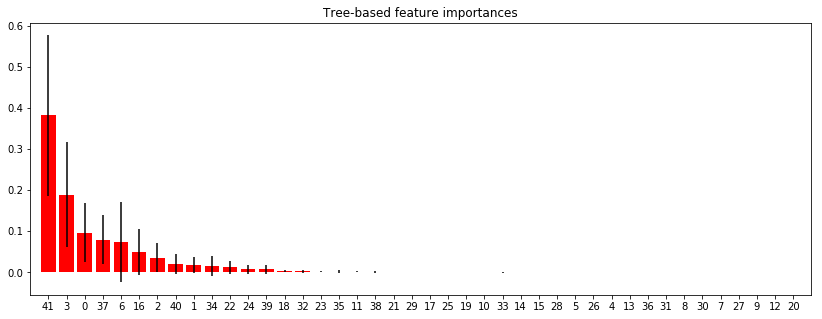

Feature ranking:
 1. WordValidityFeature                                (0.381836)
 2. ApproximateContextCoherenceFeature$trigram         (0.188405)
 3. ApproximateContextCoherenceFeature$bigram          (0.096584)
 4. ContextCoherenceFeature$bigram                     (0.079554)
 5. CharacterExistenceFeature$125 (})                  (0.073321)
 6. CharacterExistenceFeature$39 (')                   (0.049197)
 7. ApproximateContextCoherenceFeature$fourgram        (0.035205)
 8. ContextCoherenceFeature$trigram                    (0.021124)
 9. ApproximateContextCoherenceFeature$fivegram        (0.018005)
10. CharacterExistenceFeature$94 (^)                   (0.015129)
11. CharacterExistenceFeature$45 (-)                   (0.011830)
12. CharacterExistenceFeature$47 (/)                   (0.007077)
13. ContextCoherenceFeature$fourgram                   (0.006920)
14. CharacterExistenceFeature$41 ())                   (0.002887)
15. CharacterExistenceFeature$92 (\)                   (0.0

In [37]:
eval_feat_importances(get_clf('GSCV-RF'))

RandomForestClassifier

0.0238095238095


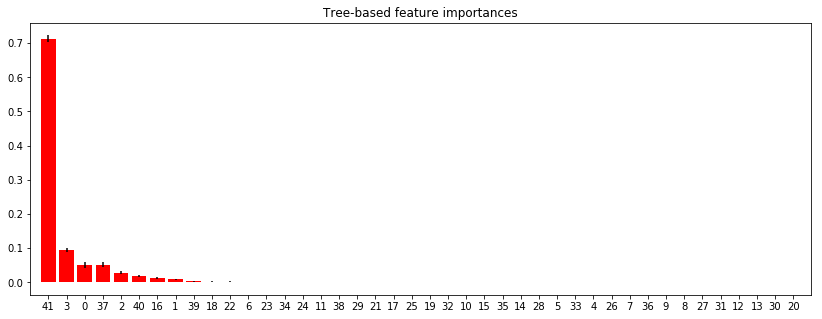

Feature ranking:
 1. WordValidityFeature                                (0.712972)
 2. ApproximateContextCoherenceFeature$trigram         (0.094789)
 3. ApproximateContextCoherenceFeature$bigram          (0.051231)
 4. ContextCoherenceFeature$bigram                     (0.050993)
 5. ApproximateContextCoherenceFeature$fourgram        (0.028207)
 6. ContextCoherenceFeature$trigram                    (0.019035)
 7. CharacterExistenceFeature$39 (')                   (0.012946)
 8. ApproximateContextCoherenceFeature$fivegram        (0.009042)
 9. ContextCoherenceFeature$fourgram                   (0.003327)
10. CharacterExistenceFeature$41 ())                   (0.002459)
11. CharacterExistenceFeature$45 (-)                   (0.002305)
12. CharacterExistenceFeature$125 (})                  (0.002206)
13. CharacterExistenceFeature$46 (.)                   (0.001803)
14. CharacterExistenceFeature$94 (^)                   (0.001340)
15. CharacterExistenceFeature$47 (/)                   (0.0

In [39]:
eval_feat_importances(get_clf('GSCV-RF-2'))

GradientBoostingClassifier

0.0238095238095


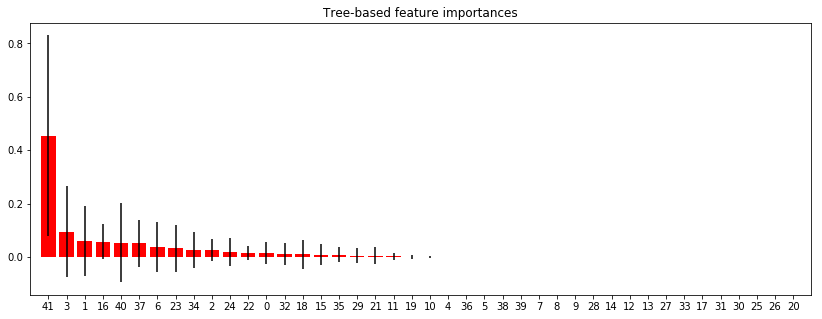

Feature ranking:
 1. WordValidityFeature                                (0.454334)
 2. ApproximateContextCoherenceFeature$trigram         (0.095107)
 3. ApproximateContextCoherenceFeature$fivegram        (0.060504)
 4. CharacterExistenceFeature$39 (')                   (0.058071)
 5. ContextCoherenceFeature$trigram                    (0.053832)
 6. ContextCoherenceFeature$bigram                     (0.050877)
 7. CharacterExistenceFeature$125 (})                  (0.037389)
 8. CharacterExistenceFeature$46 (.)                   (0.032149)
 9. CharacterExistenceFeature$94 (^)                   (0.027946)
10. ApproximateContextCoherenceFeature$fourgram        (0.025495)
11. CharacterExistenceFeature$47 (/)                   (0.019845)
12. CharacterExistenceFeature$45 (-)                   (0.016444)
13. ApproximateContextCoherenceFeature$bigram          (0.014287)
14. CharacterExistenceFeature$92 (\)                   (0.011984)
15. CharacterExistenceFeature$41 ())                   (0.0

In [40]:
eval_feat_importances(get_clf('GSCV-GradBoost'))

GradientBoostingClassifier

0.0238095238095


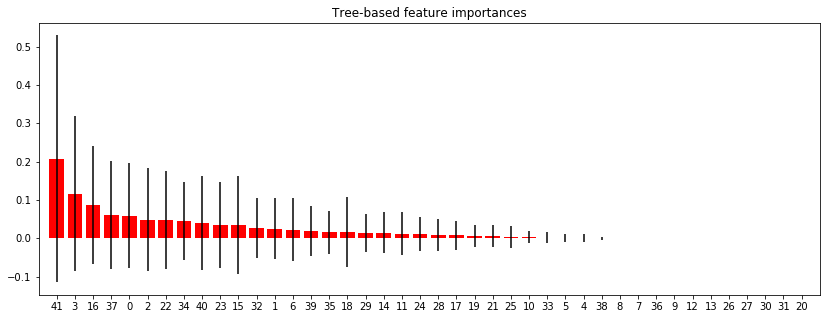

Feature ranking:
 1. WordValidityFeature                                (0.207071)
 2. ApproximateContextCoherenceFeature$trigram         (0.116331)
 3. CharacterExistenceFeature$39 (')                   (0.087629)
 4. ContextCoherenceFeature$bigram                     (0.060784)
 5. ApproximateContextCoherenceFeature$bigram          (0.058215)
 6. ApproximateContextCoherenceFeature$fourgram        (0.048491)
 7. CharacterExistenceFeature$45 (-)                   (0.047312)
 8. CharacterExistenceFeature$94 (^)                   (0.044734)
 9. ContextCoherenceFeature$trigram                    (0.039135)
10. CharacterExistenceFeature$46 (.)                   (0.034916)
11. CharacterExistenceFeature$38 (&)                   (0.034822)
12. CharacterExistenceFeature$92 (\)                   (0.027514)
13. ApproximateContextCoherenceFeature$fivegram        (0.025411)
14. CharacterExistenceFeature$125 (})                  (0.022700)
15. ContextCoherenceFeature$fourgram                   (0.0

In [41]:
eval_feat_importances(get_clf('GSCV-GradBoost-2'))

ExtraTreesClassifier

0.0238095238095


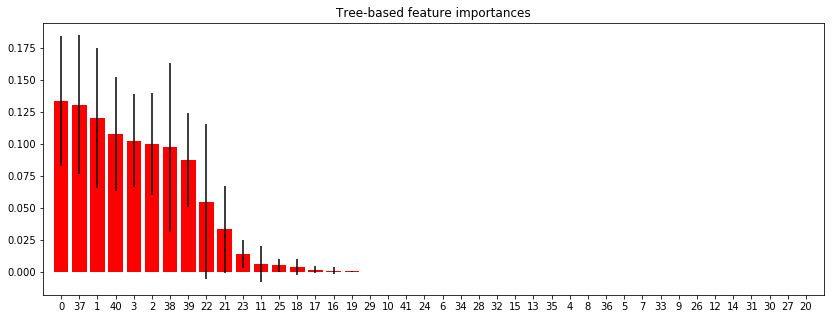

Feature ranking:
 1. ApproximateContextCoherenceFeature$bigram          0.133694 0.0506  0.0831  0.1843
 2. ContextCoherenceFeature$bigram                     0.130509 0.0543  0.0762  0.1848
 3. ApproximateContextCoherenceFeature$fivegram        0.120365 0.0545  0.0658  0.1749
 4. ContextCoherenceFeature$trigram                    0.107617 0.0447  0.0629  0.1523
 5. ApproximateContextCoherenceFeature$trigram         0.102682 0.0360  0.0666  0.1387
 6. ApproximateContextCoherenceFeature$fourgram        0.099707 0.0399  0.0598  0.1396
 7. ContextCoherenceFeature$fivegram                   0.097375 0.0662  0.0311  0.1636
 8. ContextCoherenceFeature$fourgram                   0.087444 0.0364  0.0510  0.1239
 9. CharacterExistenceFeature$45 (-)                   0.054808 0.0606 -0.0058  0.1155
10. CharacterExistenceFeature$44 (,)                   0.033192 0.0338 -0.0006  0.0670
11. CharacterExistenceFeature$46 (.)                   0.013838 0.0108  0.0031  0.0246
12. CharacterExistenceFeat

In [300]:
eval_feat_importances(get_clf('ETree.w3E8.t100'))

ExtraTreesClassifier

0.0238095238095


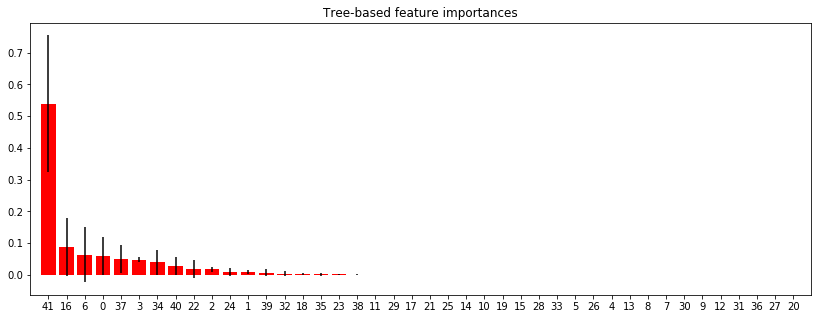

Feature ranking:
 1. WordValidityFeature                                (0.539270)
 2. CharacterExistenceFeature$39 (')                   (0.088932)
 3. CharacterExistenceFeature$125 (})                  (0.063202)
 4. ApproximateContextCoherenceFeature$bigram          (0.059427)
 5. ContextCoherenceFeature$bigram                     (0.050783)
 6. ApproximateContextCoherenceFeature$trigram         (0.048300)
 7. CharacterExistenceFeature$94 (^)                   (0.039465)
 8. ContextCoherenceFeature$trigram                    (0.028295)
 9. CharacterExistenceFeature$45 (-)                   (0.019322)
10. ApproximateContextCoherenceFeature$fourgram        (0.017449)
11. CharacterExistenceFeature$47 (/)                   (0.009665)
12. ApproximateContextCoherenceFeature$fivegram        (0.009635)
13. ContextCoherenceFeature$fourgram                   (0.007489)
14. CharacterExistenceFeature$92 (\)                   (0.004143)
15. CharacterExistenceFeature$41 ())                   (0.0

In [42]:
eval_feat_importances(get_clf('GSCV-ETree').best_estimator_)

ExtraTreesClassifier

0.0238095238095


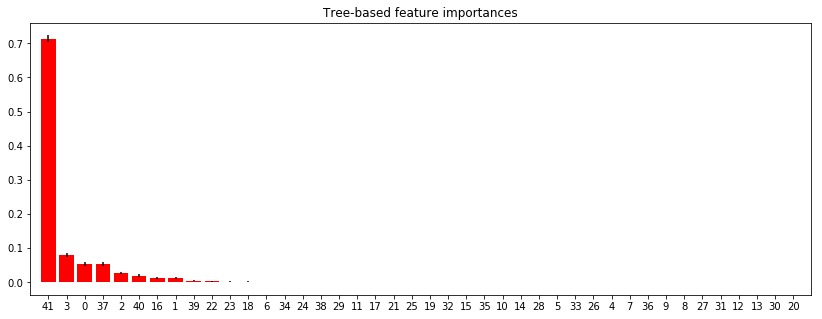

Feature ranking:
 1. WordValidityFeature                                (0.713604)
 2. ApproximateContextCoherenceFeature$trigram         (0.080500)
 3. ApproximateContextCoherenceFeature$bigram          (0.054671)
 4. ContextCoherenceFeature$bigram                     (0.054327)
 5. ApproximateContextCoherenceFeature$fourgram        (0.027978)
 6. ContextCoherenceFeature$trigram                    (0.020013)
 7. CharacterExistenceFeature$39 (')                   (0.012860)
 8. ApproximateContextCoherenceFeature$fivegram        (0.012265)
 9. ContextCoherenceFeature$fourgram                   (0.005233)
10. CharacterExistenceFeature$45 (-)                   (0.002728)
11. CharacterExistenceFeature$46 (.)                   (0.002623)
12. CharacterExistenceFeature$41 ())                   (0.002288)
13. CharacterExistenceFeature$125 (})                  (0.002156)
14. CharacterExistenceFeature$94 (^)                   (0.001361)
15. CharacterExistenceFeature$47 (/)                   (0.0

In [43]:
eval_feat_importances(get_clf('GSCV-ETree-2').best_estimator_)

ExtraTreesClassifier

0.0238095238095


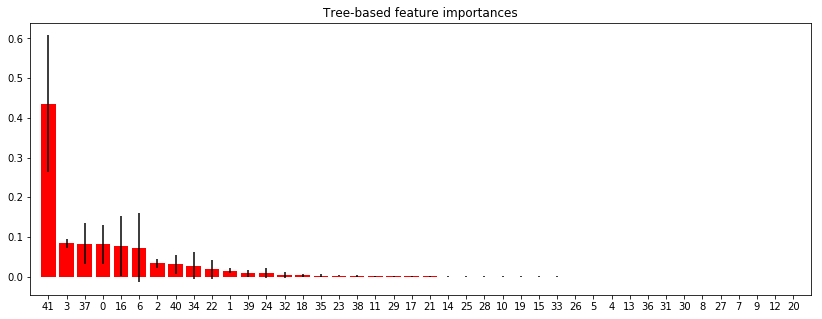

Feature ranking:
 1. WordValidityFeature                                (0.435538)
 2. ApproximateContextCoherenceFeature$trigram         (0.084082)
 3. ContextCoherenceFeature$bigram                     (0.083581)
 4. ApproximateContextCoherenceFeature$bigram          (0.081451)
 5. CharacterExistenceFeature$39 (')                   (0.077320)
 6. CharacterExistenceFeature$125 (})                  (0.073511)
 7. ApproximateContextCoherenceFeature$fourgram        (0.033446)
 8. ContextCoherenceFeature$trigram                    (0.030928)
 9. CharacterExistenceFeature$94 (^)                   (0.028173)
10. CharacterExistenceFeature$45 (-)                   (0.018425)
11. ApproximateContextCoherenceFeature$fivegram        (0.014771)
12. ContextCoherenceFeature$fourgram                   (0.009153)
13. CharacterExistenceFeature$47 (/)                   (0.009139)
14. CharacterExistenceFeature$92 (\)                   (0.004279)
15. CharacterExistenceFeature$41 ())                   (0.0

In [44]:
eval_feat_importances(get_clf('GSCV-ETree-full-sqrt').best_estimator_)

ExtraTreesClassifier

0.0238095238095


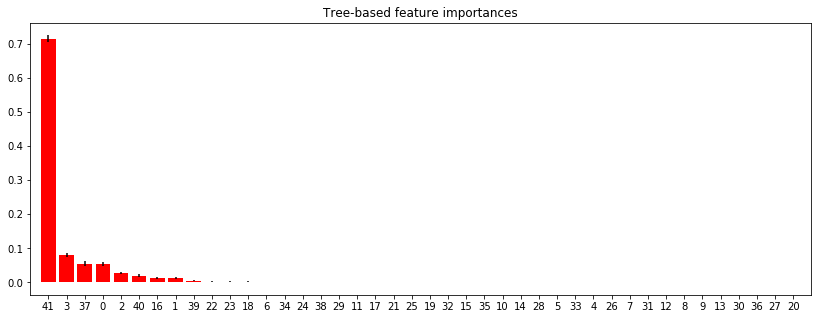

Feature ranking:
 1. WordValidityFeature                                (0.714632)
 2. ApproximateContextCoherenceFeature$trigram         (0.079641)
 3. ContextCoherenceFeature$bigram                     (0.055117)
 4. ApproximateContextCoherenceFeature$bigram          (0.053196)
 5. ApproximateContextCoherenceFeature$fourgram        (0.027748)
 6. ContextCoherenceFeature$trigram                    (0.020149)
 7. CharacterExistenceFeature$39 (')                   (0.013176)
 8. ApproximateContextCoherenceFeature$fivegram        (0.012475)
 9. ContextCoherenceFeature$fourgram                   (0.005212)
10. CharacterExistenceFeature$45 (-)                   (0.002704)
11. CharacterExistenceFeature$46 (.)                   (0.002658)
12. CharacterExistenceFeature$41 ())                   (0.002267)
13. CharacterExistenceFeature$125 (})                  (0.002130)
14. CharacterExistenceFeature$94 (^)                   (0.001309)
15. CharacterExistenceFeature$47 (/)                   (0.0

In [45]:
eval_feat_importances(get_clf('GSCV-ETree-full-all').best_estimator_)

In [46]:
from sklearn import model_selection
from sklearn import feature_selection

def feature_selection_RFECV(clf_name):
    clf = get_clf(clf_name)
    if isinstance(clf, model_selection.GridSearchCV):
        clf = clf.best_estimator_
    return feature_selection.RFECV(estimator=clf, cv=10, n_jobs=-1, scoring='accuracy')

MODELS_FEAT_OPT_TREE = [
    ['SFM-RF.RF', pipeline.Pipeline([
        ('SFM_RF', feature_selection.SelectFromModel(get_clf('RF'))),
        ('RF', ensemble.RandomForestClassifier()),
        ])
    ],
    ['SFM-RF-d5mean.RF', pipeline.Pipeline([
        ('SFM_RF', feature_selection.SelectFromModel(
            get_clf('RF'),
            threshold=get_mean_importance(get_clf('RF')) * 0.5)),
        ('RF', ensemble.RandomForestClassifier()),
        ])
    ],
    ['SFM-RF-d1mean.RF', pipeline.Pipeline([
        ('SFM_RF', feature_selection.SelectFromModel(
            get_clf('RF'),
            threshold=get_mean_importance(get_clf('RF')) * 0.1)),
        ('RF', ensemble.RandomForestClassifier()),
        ])
    ],
    ['SFM-AdaBoost.AdaBoost', pipeline.Pipeline([
        ('SFM_AdaBoost', feature_selection.SelectFromModel(get_clf('AdaBoost'))),
        ('AdaBoost', ensemble.AdaBoostClassifier()),
        ])
    ],
    ['SFM-AdaBoost-d5mean.AdaBoost', pipeline.Pipeline([
        ('SFM_AdaBoost', feature_selection.SelectFromModel(
            get_clf('AdaBoost'),
            threshold=get_mean_importance(get_clf('AdaBoost')) * 0.5)),
        ('AdaBoost', ensemble.AdaBoostClassifier()),
        ])
    ],
    ['SFM-AdaBoost-d1mean.AdaBoost', pipeline.Pipeline([
        ('SFM_AdaBoost', feature_selection.SelectFromModel(
            get_clf('AdaBoost'),
            threshold=get_mean_importance(get_clf('AdaBoost')) * 0.1)),
        ('AdaBoost', ensemble.AdaBoostClassifier()),
        ])
    ],
    ['SFM-ETree.ETree', pipeline.Pipeline([
        ('SFM_ETree', feature_selection.SelectFromModel(get_clf('ETree'))),
        ('ETree', ensemble.ExtraTreesClassifier()),
        ])
    ],
    ['SFM-ETree-d5mean.ETree', pipeline.Pipeline([
        ('SFM_AdaBoost', feature_selection.SelectFromModel(
            get_clf('ETree'),
            threshold=get_mean_importance(get_clf('ETree')) * 0.5)),
        ('ETree', ensemble.ExtraTreesClassifier()),
        ])
    ],
    ['SFM-ETree-d1mean.ETree', pipeline.Pipeline([
        ('SFM_AdaBoost', feature_selection.SelectFromModel(
            get_clf('ETree'),
            threshold=get_mean_importance(get_clf('ETree')) * 0.1)),
        ('ETree', ensemble.ExtraTreesClassifier()),
        ])
    ],
    ['RFECV-ETree', feature_selection_RFECV('ETree')
    ],
    ['RFECV-ETree.ETree', pipeline.Pipeline([
        ('SFM_ETree', feature_selection_RFECV('ETree')),
        ('ETree', ensemble.ExtraTreesClassifier()),
        ])
    ],
    ['RFECV-GSCV-ETree.ETree', pipeline.Pipeline([
        ('SFM_ETree', feature_selection_RFECV('GSCV-ETree')),
        ('ETree', ensemble.ExtraTreesClassifier()),
        ])
    ],
    ['RFECV-GSCV-ETree.GSCV-ETree', pipeline.Pipeline([
        ('SFM_ETree', feature_selection_RFECV('GSCV-ETree')),
        ('GSCV_ETree', model_selection_GridSearchCV(ensemble.ExtraTreesClassifier(), {
            'n_estimators': np.arange(50, 250, 50),
            'min_samples_split': np.arange(2, 10),
            })),
        ])
    ],
#     ['RFECV-GSCV-ETree-full-all.GSCV-ETree', pipeline.Pipeline([
#         ('SFM_ETree', feature_selection_RFECV('GSCV-ETree-full-all')),
#         ('GSCV_ETree', model_selection_GridSearchCV(ensemble.ExtraTreesClassifier(), {
#             'n_estimators': np.arange(50, 250, 50),
#             'min_samples_split': np.arange(2, 10),
#             })),
#         ])
#     ],
    ['SFM-GradBoost.GradBoost', pipeline.Pipeline([
        ('SFM_BradBoost', feature_selection.SelectFromModel(get_clf('GradBoost'))),
        ('BradBoost', ensemble.GradientBoostingClassifier()),
        ])
    ],
    ['SFM-GradBoost-d5mean.GradBoost', pipeline.Pipeline([
        ('SFM_GradBoost', feature_selection.SelectFromModel(
            get_clf('GradBoost'),
            threshold=get_mean_importance(get_clf('GradBoost')) * 0.5)),
        ('ETree', ensemble.GradientBoostingClassifier()),
        ])
    ],
    ['SFM-GradBoost-d1mean.GradBoost', pipeline.Pipeline([
        ('SFM_GradBoost', feature_selection.SelectFromModel(
            get_clf('GradBoost'),
            threshold=get_mean_importance(get_clf('GradBoost')) * 0.1)),
        ('ETree', ensemble.GradientBoostingClassifier()),
        ])
    ],
    ['RFECV-GradBoost', feature_selection_RFECV('GradBoost')
    ],
    ['RFECV-GradBoost.GradBoost', pipeline.Pipeline([
        ('SFM_GradBoost', feature_selection_RFECV('GradBoost')),
        ('ETree', ensemble.GradientBoostingClassifier()),
        ])
    ],
]

In [47]:
train(MODELS_FEAT_OPT_TREE)

SFM-RF.RF                      ..... SKIPPED
SFM-RF-d5mean.RF               ..... SKIPPED
SFM-RF-d1mean.RF               ..... SKIPPED
SFM-AdaBoost.AdaBoost          ..... SKIPPED
SFM-AdaBoost-d5mean.AdaBoost   ..... SKIPPED
SFM-AdaBoost-d1mean.AdaBoost   ..... SKIPPED
SFM-ETree.ETree                ..... SKIPPED
SFM-ETree-d5mean.ETree         ..... SKIPPED
SFM-ETree-d1mean.ETree         ..... SKIPPED
RFECV-ETree                    ..... SKIPPED
RFECV-ETree.ETree              ..... SKIPPED
RFECV-GSCV-ETree.ETree         ..... SKIPPED
RFECV-GSCV-ETree.GSCV-ETree    ..... SKIPPED
SFM-GradBoost.GradBoost        ..... SKIPPED
SFM-GradBoost-d5mean.GradBoost ..... SKIPPED
SFM-GradBoost-d1mean.GradBoost ..... SKIPPED
RFECV-GradBoost                ..... SKIPPED
RFECV-GradBoost.GradBoost      ..... SKIPPED


In [48]:
test(MODELS_FEAT_OPT_TREE)

SFM-RF.RF                      ..... 0.984089
SFM-RF-d5mean.RF               ..... 0.984196
SFM-RF-d1mean.RF               ..... 0.984035
SFM-AdaBoost.AdaBoost          ..... 0.983229
SFM-AdaBoost-d5mean.AdaBoost   ..... 0.983336
SFM-AdaBoost-d1mean.AdaBoost   ..... 0.983336
SFM-ETree.ETree                ..... 0.984304
SFM-ETree-d5mean.ETree         ..... 0.984357
SFM-ETree-d1mean.ETree         ..... 0.984142
RFECV-ETree                    ..... 0.983659
RFECV-ETree.ETree              ..... 0.984250
RFECV-GSCV-ETree.ETree         ..... 0.984357
RFECV-GSCV-ETree.GSCV-ETree    ..... 0.984465
SFM-GradBoost.GradBoost        ..... 0.983659
SFM-GradBoost-d5mean.GradBoost ..... 0.983981
SFM-GradBoost-d1mean.GradBoost ..... 0.983981
RFECV-GradBoost                ..... 0.983766
RFECV-GradBoost.GradBoost      ..... 0.983659


In [49]:
get_clf('RFECV-GSCV-ETree.GSCV-ETree').steps[1].best_estimator_

AttributeError: 'tuple' object has no attribute 'best_estimator_'

In [50]:
import operator

def eval_opt_feats(rfecv):
    print('Optimal number of features : %d' % rfecv.n_features_)

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel('Number of features selected')
    plt.ylabel('Cross validation score (nb of correct classifications)')
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
    ranked = [(k, v) for k, v in sorted(zip(FEATS_TRAIN.columns, rfecv.ranking_),
                                        key=operator.itemgetter(1))]
    for name, rank in ranked:
        sys.stdout.write('%2s. %s' % (rank, name))
        if 'CharacterExistenceFeature' in name:
            char = chr(int(name[26:]))
            sys.stdout.write(' ' + char)
        print()

Optimal number of features : 5


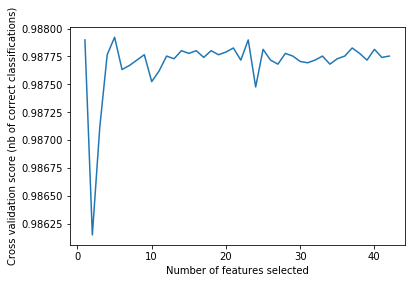

 1. ApproximateContextCoherenceFeature$bigram
 1. ApproximateContextCoherenceFeature$trigram
 1. CharacterExistenceFeature$39 '
 1. ContextCoherenceFeature$bigram
 1. WordValidityFeature
 2. CharacterExistenceFeature$125 }
 3. ApproximateContextCoherenceFeature$fourgram
 4. ContextCoherenceFeature$trigram
 5. ApproximateContextCoherenceFeature$fivegram
 6. CharacterExistenceFeature$45 -
 7. CharacterExistenceFeature$94 ^
 8. ContextCoherenceFeature$fourgram
 9. CharacterExistenceFeature$41 )
10. CharacterExistenceFeature$46 .
11. CharacterExistenceFeature$47 /
12. CharacterExistenceFeature$95 _
13. CharacterExistenceFeature$92 \
14. CharacterExistenceFeature$34 "
15. CharacterExistenceFeature$63 ?
16. CharacterExistenceFeature$40 (
17. CharacterExistenceFeature$44 ,
18. ContextCoherenceFeature$fivegram
19. CharacterExistenceFeature$59 ;
20. CharacterExistenceFeature$38 &
21. CharacterExistenceFeature$42 *
22. CharacterExistenceFeature$33 !
23. CharacterExistenceFeature$62 >
24. Charact

In [51]:
eval_opt_feats(get_clf('RFECV-ETree'))

Optimal number of features : 18


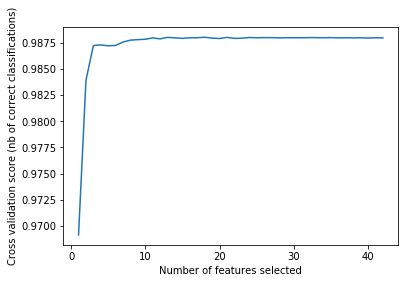

 1. ApproximateContextCoherenceFeature$bigram
 1. ApproximateContextCoherenceFeature$fivegram
 1. ApproximateContextCoherenceFeature$fourgram
 1. ApproximateContextCoherenceFeature$trigram
 1. CharacterExistenceFeature$125 }
 1. CharacterExistenceFeature$37 %
 1. CharacterExistenceFeature$38 &
 1. CharacterExistenceFeature$39 '
 1. CharacterExistenceFeature$45 -
 1. CharacterExistenceFeature$46 .
 1. CharacterExistenceFeature$47 /
 1. CharacterExistenceFeature$62 >
 1. CharacterExistenceFeature$92 \
 1. CharacterExistenceFeature$94 ^
 1. CharacterExistenceFeature$95 _
 1. ContextCoherenceFeature$bigram
 1. ContextCoherenceFeature$trigram
 1. WordValidityFeature
 2. CharacterExistenceFeature$63 ?
 3. ContextCoherenceFeature$fourgram
 4. CharacterExistenceFeature$44 ,
 5. CharacterExistenceFeature$124 |
 6. CharacterExistenceFeature$33 !
 7. CharacterExistenceFeature$41 )
 8. CharacterExistenceFeature$34 "
 9. CharacterExistenceFeature$40 (
10. CharacterExistenceFeature$42 *
11. Characte

In [52]:
eval_opt_feats(get_clf('RFECV-GradBoost'))

## Writeout Labels

In [301]:
# CLF_NAME = 'GSCV-ETree'
CLF_NAME = 'ETree.w3E8.t100'

In [303]:
LABEL_PATH = TEMP_PATH + '/detect/label'

if not os.path.exists(LABEL_PATH):
    os.makedirs(LABEL_PATH)
path = LABEL_PATH + '/labels.tsv'
clf = joblib.load(get_pkl_path(CLF_NAME))
labels = clf.predict(FEATS_TEST)
with open(path, 'w') as f:
    f.write('\n'.join(str(v) for v in labels))